# Poetry Generation
Here we will generate poetry on a bigger text corpus, expecting better results here

In [1]:
import numpy as np
import tensorflow as tf

In [2]:
! wget --no-check-certificate https://raw.githubusercontent.com/https-deeplearning-ai/tensorflow-1-public/main/C3/W4/misc/Laurences_generated_poetry.txt -O irish-poetry-text-corpus.txt

--2024-01-10 14:05:50--  https://raw.githubusercontent.com/https-deeplearning-ai/tensorflow-1-public/main/C3/W4/misc/Laurences_generated_poetry.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69001 (67K) [text/plain]
Saving to: ‘irish-poetry-text-corpus.txt’

irish-poetry-text-c 100%[===================>]  67.38K  --.-KB/s    in 0.007s  

2024-01-10 14:05:50 (9.30 MB/s) - ‘irish-poetry-text-corpus.txt’ saved [69001/69001]



## Data preprocessing

In [115]:
sentences = []
with open('./irish-poetry-text-corpus.txt', 'r') as poetry:
    sentences = poetry.read()
    sentences = sentences.lower().split('\n')

print(len(sentences))
print(sentences)

1692
['come all ye maidens young and fair', 'and you that are blooming in your prime', 'always beware and keep your garden fair', 'let no man steal away your thyme', 'for thyme it is a precious thing', 'and thyme brings all things to my mind', 'nlyme with all its flavours, along with all its joys', 'thyme, brings all things to my mind', 'once i and a bunch of thyme', 'i thought it never would decay', 'then came a lusty sailor', 'who chanced to pass my way', 'and stole my bunch of thyme away', 'the sailor gave to me a rose', 'a rose that never would decay', 'he gave it to me to keep me reminded', 'of when he stole my thyme away', 'sleep, my child, and peace attend thee', 'all through the night', 'guardian angels god will send thee', 'soft the drowsy hours are creeping', 'hill and dale in slumber sleeping', 'i my loving vigil keeping', 'while the moon her watch is keeping', 'while the weary world is sleeping', 'oer thy spirit gently stealing', 'visions of delight revealing', 'breathes a 

In [116]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

# Adding 1 for padding character, which is not counted by the word_index
VOCAB_SIZE = len(tokenizer.word_index) + 1
print(VOCAB_SIZE)

2690


In [117]:
# Last number is never counted

arr = list(range(1, 10))
print(arr)

[1, 2, 3, 4, 5, 6, 7, 8, 9]


In [118]:
ip_sntncs = []
max_len = 0

for line in sentences:
    words = line.split(' ')
    for i in range(1, len(words)):
        ip_sntncs.append(' '.join(words[:i+1]))
    max_len = max(max_len, len(words))

MAX_SNTNC_LEN = max_len - 1

In [119]:
print(MAX_SNTNC_LEN)
print(VOCAB_SIZE)

15
2690


In [120]:
ip_seqs = tokenizer.texts_to_sequences(ip_sntncs) 
ip_pad_seqs = pad_sequences(ip_seqs, padding='pre')

print(ip_pad_seqs.shape)
print(ip_pad_seqs[0])

(11979, 16)
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 51 12]


In [121]:
train_data = ip_pad_seqs[:,:-1]
train_labels = ip_pad_seqs[:,-1]

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=VOCAB_SIZE)
print(type(train_data))
print(train_data.shape)
print(train_labels.shape)

<class 'numpy.ndarray'>
(11979, 15)
(11979, 2690)


In [122]:
from random import randint
rand_indx = randint(0, len(ip_sntncs))

print(ip_sntncs[rand_indx])
print('Encoded Version', train_data[rand_indx])
print('Decoded Version', tokenizer.sequences_to_texts([train_data[rand_indx]]))
print('Encoded Label',np.argmax(train_labels[rand_indx]))
print('Decoded Label', tokenizer.index_word[np.argmax(train_labels[rand_indx])])


as when she held
Encoded Version [ 0  0  0  0  0  0  0  0  0  0  0  0 20 21 14]
Decoded Version ['as when she']
Encoded Label 837
Decoded Label held


## Model Creation

Hyperparameters

In [144]:
EMBED_SIZE = 64
LSTM_UNITS = 64
DENSE_UNITS = 32
LEARNING_RATE = 1e-2
EPOCHS = 256

In [145]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional

model = Sequential([
    Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SNTNC_LEN),
    Bidirectional(LSTM(LSTM_UNITS)),

    Dense(DENSE_UNITS, activation='relu'),
    Dense(VOCAB_SIZE, activation='softmax')
])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 15, 64)            172160    
                                                                 
 bidirectional_7 (Bidirecti  (None, 128)               66048     
 onal)                                                           
                                                                 
 dense_14 (Dense)            (None, 32)                4128      
                                                                 
 dense_15 (Dense)            (None, 2690)              88770     
                                                                 
Total params: 331106 (1.26 MB)
Trainable params: 331106 (1.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [146]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(lr=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## Model Training

In [147]:
hist_data = model.fit(train_data, train_labels, epochs=EPOCHS)

Epoch 1/256
375/375 [==============================] - 4s 6ms/step - loss: 6.7915 - accuracy: 0.0639
Epoch 2/256
375/375 [==============================] - 2s 6ms/step - loss: 6.3111 - accuracy: 0.0661
Epoch 3/256
375/375 [==============================] - 2s 6ms/step - loss: 6.1550 - accuracy: 0.0675
Epoch 4/256
375/375 [==============================] - 2s 6ms/step - loss: 6.0197 - accuracy: 0.0745
Epoch 5/256
375/375 [==============================] - 2s 6ms/step - loss: 5.8959 - accuracy: 0.0823
Epoch 6/256
375/375 [==============================] - 2s 6ms/step - loss: 5.7888 - accuracy: 0.0889
Epoch 7/256
375/375 [==============================] - 2s 6ms/step - loss: 5.6865 - accuracy: 0.0943
Epoch 8/256
375/375 [==============================] - 2s 6ms/step - loss: 5.5925 - accuracy: 0.0997
Epoch 9/256
375/375 [==============================] - 2s 6ms/step - loss: 5.4960 - accuracy: 0.1048
Epoch 10/256
375/375 [==============================] - 2s 6ms/step - loss: 5.4044 - accura

## Plotting Metrics

In [148]:
import matplotlib.pyplot as plt

def plot_graph(metrics, kind):
    plt.plot(metrics[kind], label=kind)
    plt.xlabel('epochs')
    plt.ylabel(kind)
    plt.title(kind)
    plt.legend()
    plt.show()

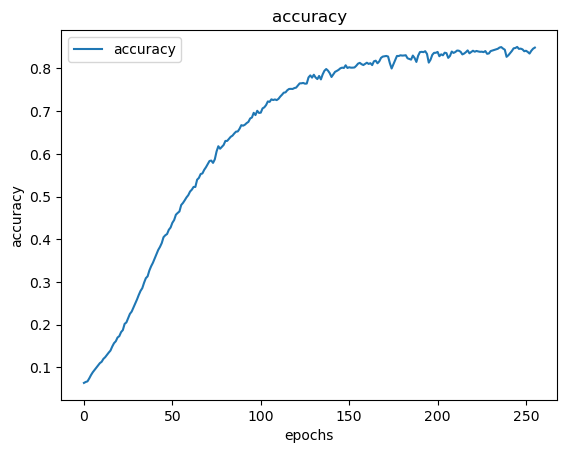

In [149]:
plot_graph(hist_data.history, 'accuracy')

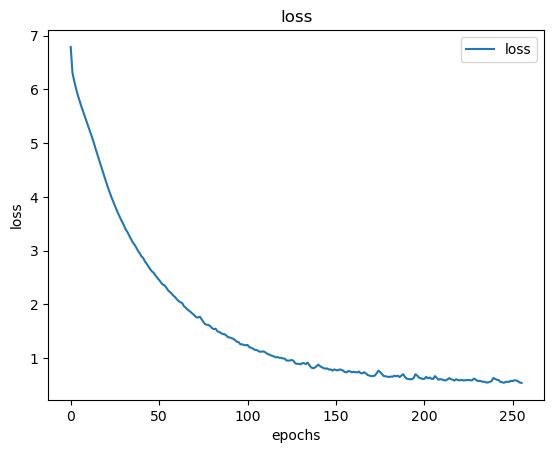

In [150]:
plot_graph(hist_data.history, 'loss')

## Text Generation

In [151]:
PREDICT_WORDS = 10 # Next No. of words to predict here

In [152]:
seed_text = 'With love of rabbit'
for _ in range(PREDICT_WORDS):
    seq = tokenizer.texts_to_sequences([seed_text])
    pad_seq = pad_sequences(seq, padding='pre', maxlen=MAX_SNTNC_LEN)
    prediction = model.predict(pad_seq)
    word_idx = np.argmax(prediction, axis=1)[0]

    if word_idx != 0:
        word = tokenizer.index_word[word_idx]
        seed_text = seed_text + ' ' + word

print(seed_text)

1/1 [==============================] - 0s 10ms/step
With love of rabbit the road to dublin whack follol soar dying gone a


In [153]:
import textwrap
print(textwrap.fill(seed_text, width=40))

With love of rabbit the road to dublin
whack follol soar dying gone a


In [154]:
seed_text2 = 'My name is anthony o lanigen'

for _ in range(PREDICT_WORDS):
    seq = tokenizer.texts_to_sequences([seed_text2])
    pad_seq = pad_sequences(seq, padding='pre', maxlen=MAX_SNTNC_LEN)
    prediction = model.predict(pad_seq)
    word_idx = np.argsort(prediction, axis=1)
    rand_choice = np.random.choice(word_idx[0][-3:])
    if rand_choice != 0:
        word = tokenizer.index_word[rand_choice]
        seed_text2 = seed_text2 + ' ' + word

print(seed_text2)

1/1 [==============================] - 0s 9ms/step
My name is anthony o lanigen heard the sea for queer the still lightly gone behind


In [155]:
import textwrap
print(textwrap.fill(seed_text2, width=40))

My name is anthony o lanigen heard the
sea for queer the still lightly gone
behind


In [156]:
arr = ['a','b','c','d','e']
print(arr[-3:])

['c', 'd', 'e']
